In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())    

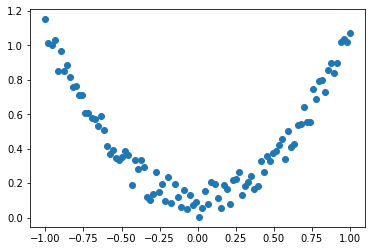

In [3]:
plt.scatter(x.numpy(), y.numpy())

## 搭建两层含有bias的全连接网络，隐藏层输出个数为20，激活函数都用sigmoid()

In [4]:
class Net(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(n_feature, n_hidden, bias=True)

        self.activation = nn.Sigmoid()

        self.linear2 = nn.Linear(n_hidden, n_output, bias=True)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

Net(
  (linear1): Linear(in_features=1, out_features=20, bias=True)
  (activation): Sigmoid()
  (linear2): Linear(in_features=20, out_features=1, bias=True)
)


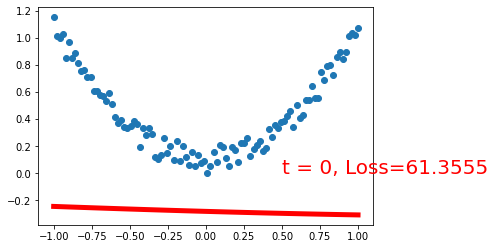

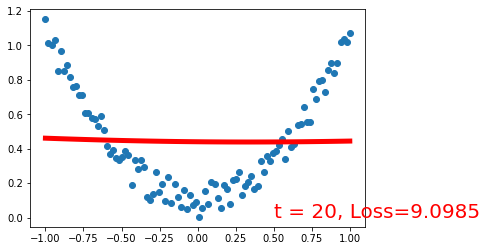

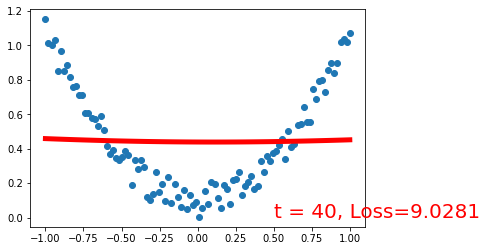

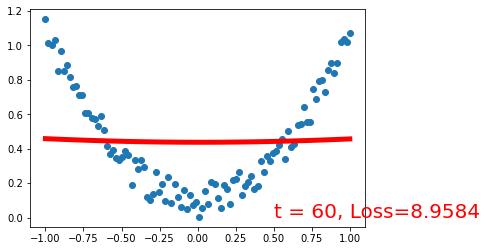

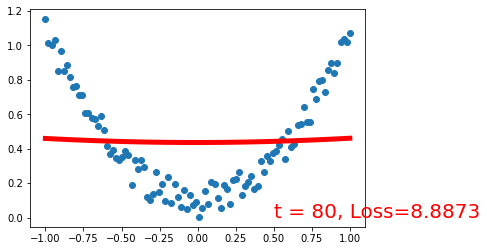

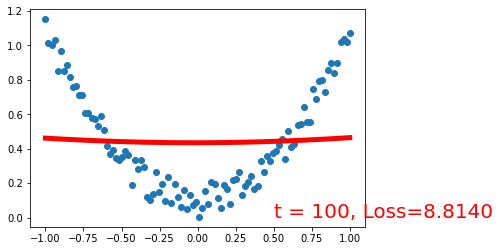

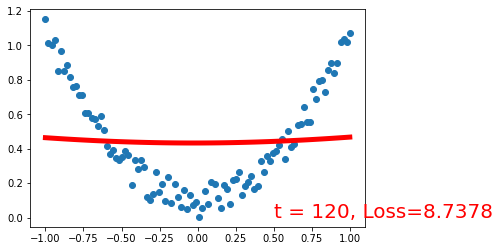

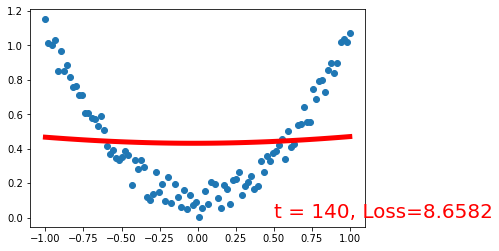

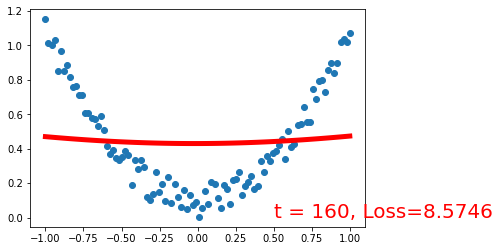

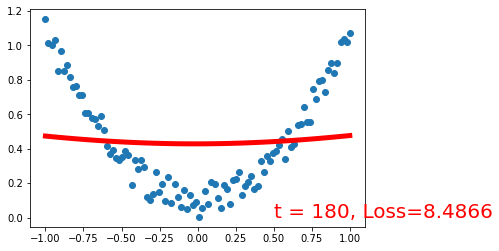

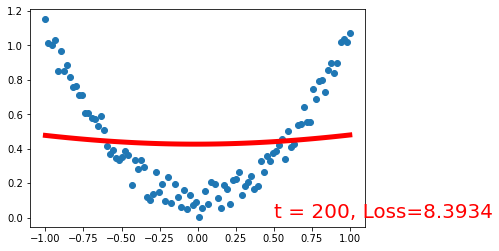

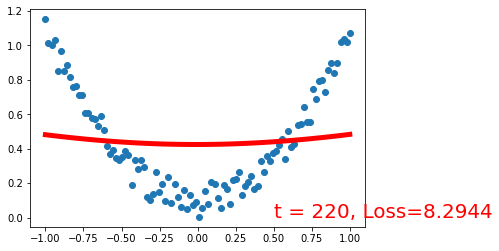

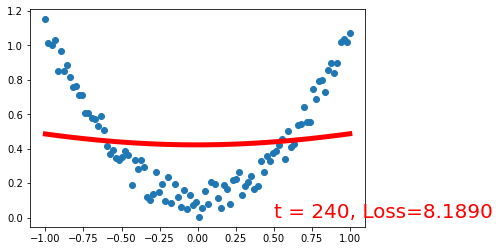

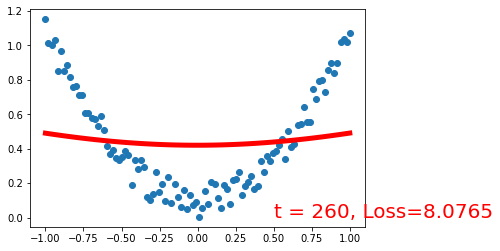

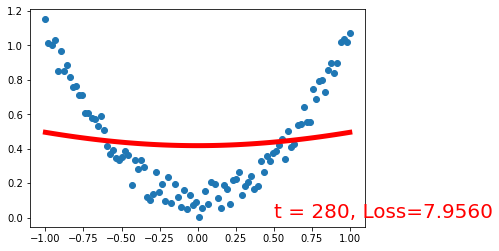

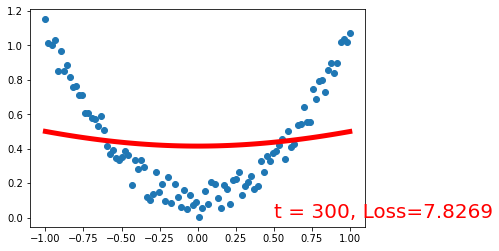

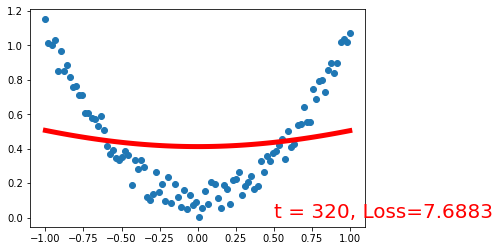

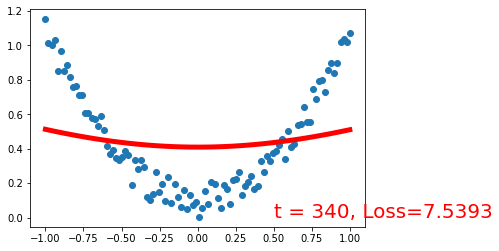

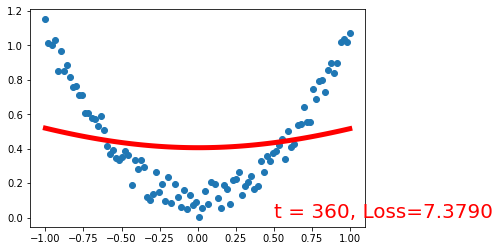

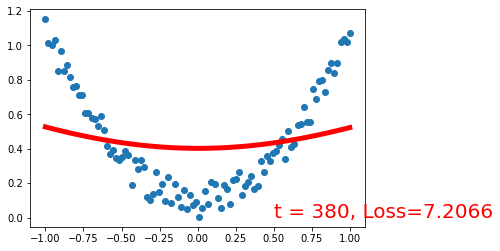

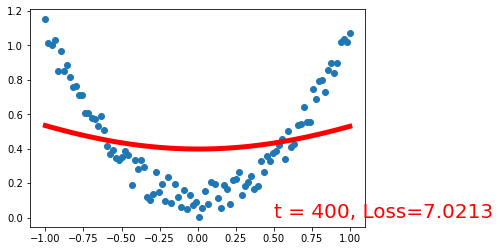

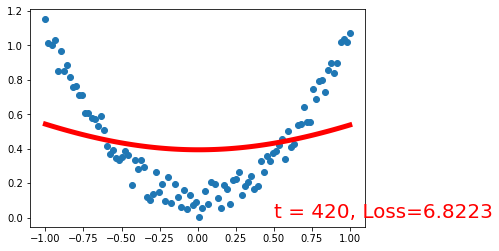

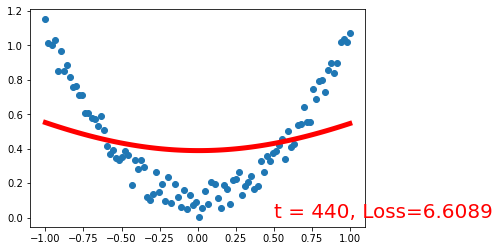

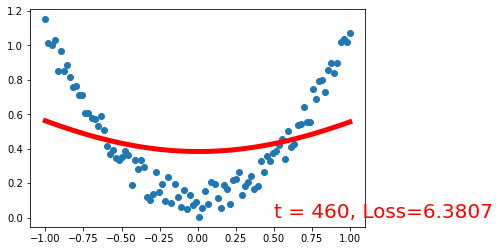

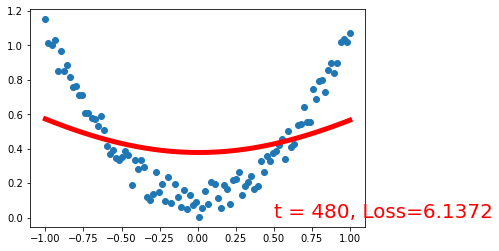

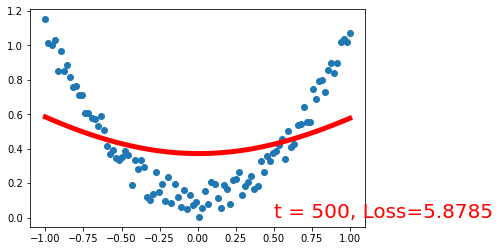

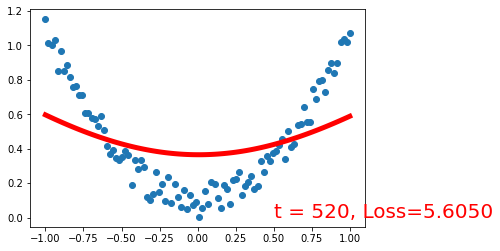

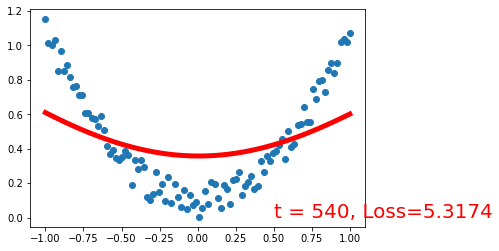

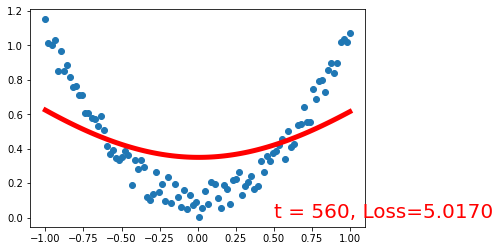

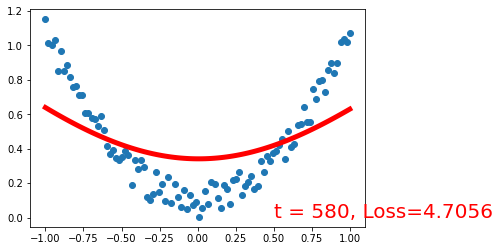

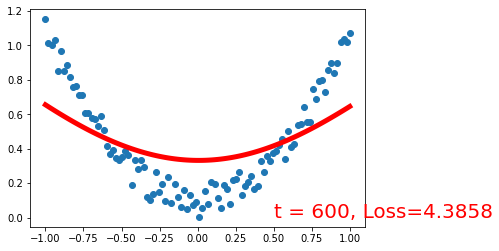

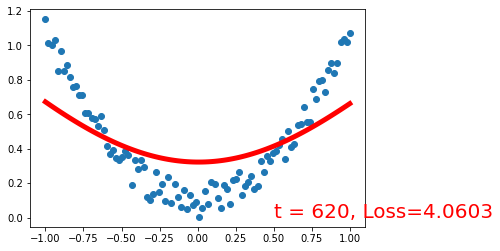

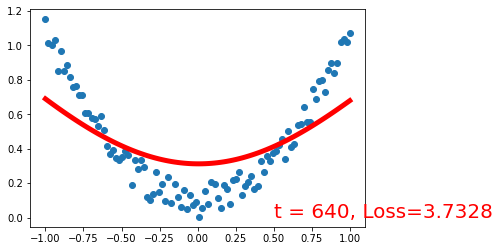

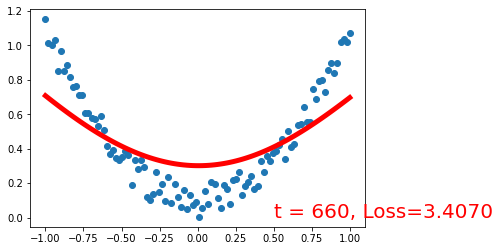

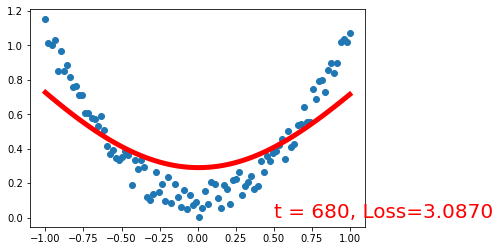

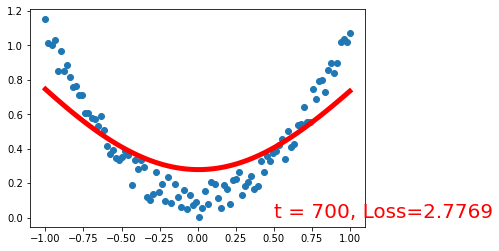

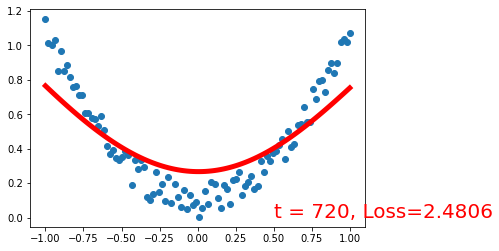

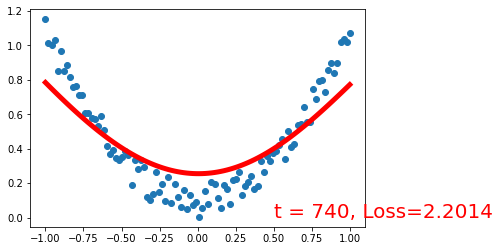

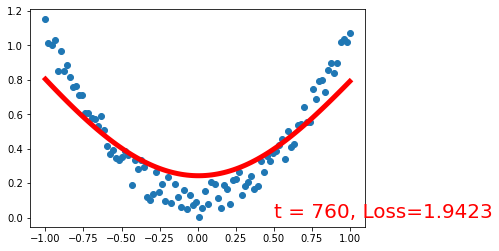

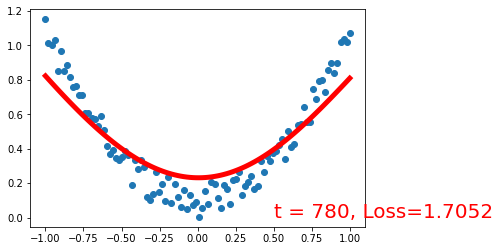

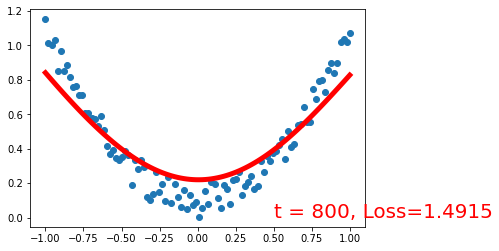

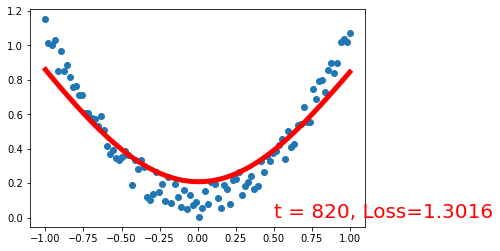

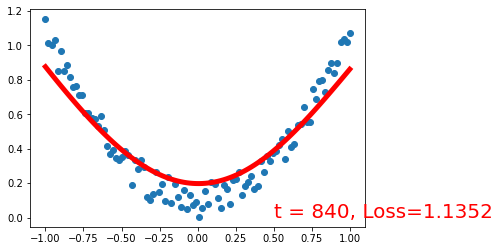

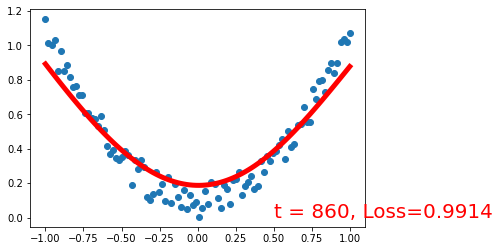

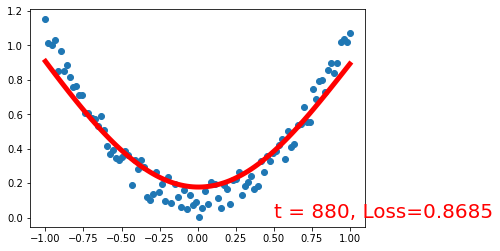

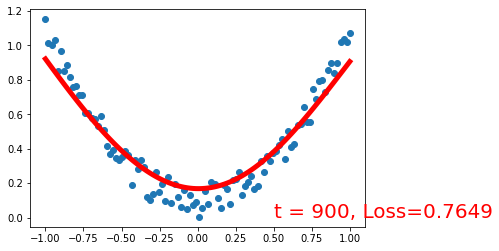

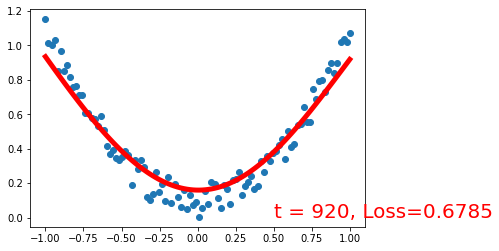

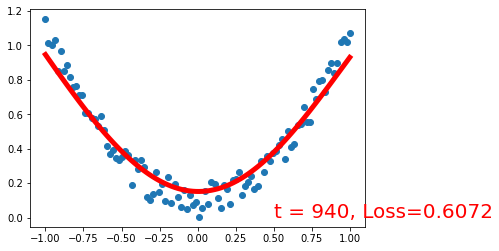

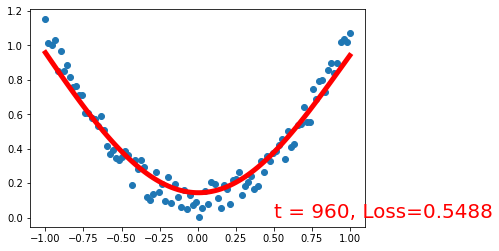

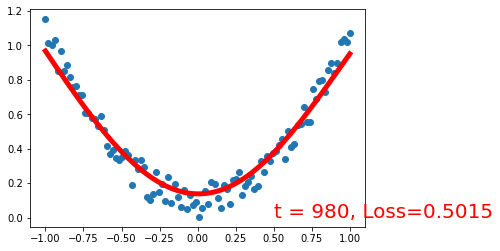

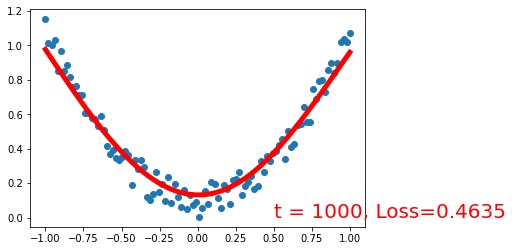

In [5]:
net = Net(n_feature=1, n_hidden=20, n_output=1)     # define the network
print(net)  # net architecture
optimizer = torch.optim.SGD(net.parameters(), lr=0.002)
loss_func = torch.nn.MSELoss(reduction='sum')  # this is for regression mean squared loss

plt.ion()   # something about plotting



for t in range(1001):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 20 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 't = %d, Loss=%.4f' % (t, loss.data.numpy()), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)
        plt.show()

plt.ioff()
# plt.show()

# Homework

![](homework_5.png)

## MSE loss (sum wise)

![](MSE_Loss.png)

equal to:

```python
f = torch.trace((y - prediction).t() @ (y - prediction))
```

## nn.Linear

![](torch.nn.linear_doc.png)

Linear layer is: `X @ W.T + B`

W2 梯度推导:

![](W2_grad.png)

B2 梯度推导:

![](B2_grad.png)

W1 梯度推导:

![](W1_grad.png)

B1 梯度推导:

![](B1_grad.png)

In [6]:

# XXX: init a new network to avoid gradient from steps before.
net = Net(n_feature=1, n_hidden=20, n_output=1)     # define the network

# XXX: net forward (The pytorch linear implementation is: X @ W.t() + B):
# H  = X @ W1.t() + B1
# Hs = sigmoid(H)
# Yp = Hs @ W2.t() + B2
# don't match with ppt expression format.
W1 = net.linear1.weight.t()
B1 = net.linear1.bias
W2 = net.linear2.weight.t()
B2 = net.linear2.bias

# Data & Label defenition
x = torch.randn((1, 1)).float()
y = x.pow(2) + 0.2*torch.rand(x.size())

prediction = net(x)

# 1. MSE loss (sum wise)
loss_func = torch.nn.MSELoss(reduction='sum')  # this is for regression mean squared loss
loss = loss_func(prediction, y)
# 2. squared F-norm of (y - prediction)
f = torch.trace((y - prediction).t() @ (y - prediction))
# These two implementation is equal.
print('===================')
print(f'Sum wise MSE loss: \n{loss} \nsquared F-norm of (y - prediction): \n{f}')
print(f'match results: {torch.allclose(loss, f)}')

loss.backward()

# W2 grad 
W2_grad = -2 * F.sigmoid(x @ W1 + B1).t() @ (y - prediction) 
W2_autograd = net.linear2.weight.grad.t()
print('===================')
print(f'W2 torch gradient: \n{W2_autograd} \nW2 matrix partial derivative results: \n{W2_grad}')
print(f'match results: {torch.allclose(W2_autograd, W2_grad)}')

# B2 grad
B2_grad = -2 * (y - prediction).t()
B2_autograd = net.linear2.bias.grad
print('===================')
print(f'B2 torch gradient: \n{B2_autograd} \nB2 matrix partial derivative results: \n{B2_grad}')
print(f'match results: {torch.allclose(B2_autograd, B2_grad)}')

# W1 grad
W1_grad = -2 * x.t() @ ((y - prediction) @ W2.t()) * (torch.exp(x @ W1 + B1) / torch.square(1 + torch.exp(x @ W1 + B1))) 
W1_autograd = net.linear1.weight.grad.t()
print('===================')
print(f'W1 torch gradient: \n{W1_autograd} \nW1 matrix partial derivative results: \n{W1_grad}')
print(f'match results: {torch.allclose(W1_autograd, W1_grad)}')

# B1 grad
B1_grad = -2 * ((y - prediction) @ W2.t()) * (torch.exp(x @ W1 + B1) / torch.square(1 + torch.exp(x @ W1 + B1))) 
B1_autograd = net.linear1.bias.grad
print('===================')
print(f'B1 torch gradient: \n{B1_autograd} \nB1 matrix partial derivative results: \n{B1_grad}')
print(f'match results: {torch.allclose(B1_autograd, B1_grad)}')

Sum wise MSE loss: 
3.259528160095215 
squared F-norm of (y - prediction): 
3.259528160095215
match results: True
W2 torch gradient: 
tensor([[-2.2500],
        [-1.4701],
        [-2.4798],
        [-0.6973],
        [-2.8053],
        [-0.7047],
        [-0.8881],
        [-0.8086],
        [-0.8154],
        [-1.7091],
        [-2.0422],
        [-1.6321],
        [-2.1889],
        [-3.2628],
        [-2.4720],
        [-2.9544],
        [-2.4053],
        [-1.7411],
        [-2.2354],
        [-1.6818]]) 
W2 matrix partial derivative results: 
tensor([[-2.2500],
        [-1.4701],
        [-2.4798],
        [-0.6973],
        [-2.8053],
        [-0.7047],
        [-0.8881],
        [-0.8086],
        [-0.8154],
        [-1.7091],
        [-2.0422],
        [-1.6321],
        [-2.1889],
        [-3.2628],
        [-2.4720],
        [-2.9544],
        [-2.4053],
        [-1.7411],
        [-2.2354],
        [-1.6818]], grad_fn=<MmBackward>)
match results: True
B2 torch gradient: 
te

D:\Software\miniconda3\envs\pt1.8\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
